Alice Simon, Céline Carré et Lucie Engel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

https://www.kaggle.com/code/vatsalmavani/pytorch-lung-segmentation-using-pretrained-u-net

# Dataset

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

Reference : Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

!pip install segmentation-models-pytorch# Load data


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e53707793d2a2a9530c53f601c7633a1cb2bd18ac0b5df8d1b9e56b57a431b65
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=8203086e001a29450000a627cfc3badc7794f7b3057b7ccb11e99e28cf7d046a
  Stored in directory: /root/.cache/pip/w

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pathlib
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import os 
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import torch.optim as optim 
torch.manual_seed(25)
import segmentation_models_pytorch as smp

In [ ]:
cd "/content/drive/MyDrive/Projet_DL/Dataset_BUSI_with_GT"

/content/drive/MyDrive/Projet_DL/Dataset_BUSI_with_GT


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# inspi https://www.kaggle.com/code/vanvalkenberg/segmentation-model-for-breast-cancer

def load_data(path, shape):
    names = os.listdir(path)
    
    patient_num = []
    ultrasound_path = []
    mask_path = []
    
    for i in range(len(names)):
        patient_num.append(names[i].split(')')[0])

    patient_num = list(set(patient_num))

    for i in range(len(patient_num)):
        ultrasound_name = patient_num[i]+').png'
        mask_name = patient_num[i]+')_mask.png'
        ultrasound_path.append(os.path.join(path,ultrasound_name))
        mask_path.append(os.path.join(path,mask_name))
    
    dict = {'ultrasound_path': ultrasound_path, 'mask_path': mask_path, 'class' : [path]*len(ultrasound_path)}
    return pd.DataFrame(dict) 

In [ ]:
SHAPE = 256
benign_df = load_data('benign', SHAPE)
malignant_df = load_data('malignant', SHAPE)
normal_df = load_data('normal', SHAPE)

data_df = pd.concat([benign_df, malignant_df, normal_df])
data_df # 780 exams 

,ultrasound_path,mask_path,class
0,benign/benign (255).png,benign/benign (255)_mask.png,benign
1,benign/benign (376).png,benign/benign (376)_mask.png,benign
2,benign/benign (404).png,benign/benign (404)_mask.png,benign
3,benign/benign (410).png,benign/benign (410)_mask.png,benign
4,benign/benign (392).png,benign/benign (392)_mask.png,benign
...,...,...,...
128,normal/normal (68).png,normal/normal (68)_mask.png,normal
129,normal/normal (55).png,normal/normal (55)_mask.png,normal
130,normal/normal (47).png,normal/normal (47)_mask.png,normal
131,normal/normal (129).png,normal/normal (129)_mask.png,normal


In [ ]:
data_df = pd.read_csv("whole_dataset_df.csv")

## Tain, Valid and Test Set

In [ ]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['class'], random_state = 11)

train_and_valid_df # 702 samples
test_df # 78 samples

train_df, valid_df = train_test_split(train_and_valid_df, test_size=0.2, stratify=train_and_valid_df['class'], random_state = 11)

In [ ]:
train_df # 561 samples
valid_df # 141 samples

,Unnamed: 0,ultrasound_path,mask_path,class
756,109,normal/normal (28).png,normal/normal (28)_mask.png,normal
25,25,benign/benign (56).png,benign/benign (56)_mask.png,benign
457,20,malignant/malignant (198).png,malignant/malignant (198)_mask.png,malignant
686,39,normal/normal (69).png,normal/normal (69)_mask.png,normal
510,73,malignant/malignant (19).png,malignant/malignant (19)_mask.png,malignant
...,...,...,...,...
350,350,benign/benign (199).png,benign/benign (199)_mask.png,benign
327,327,benign/benign (159).png,benign/benign (159)_mask.png,benign
424,424,benign/benign (93).png,benign/benign (93)_mask.png,benign
469,32,malignant/malignant (76).png,malignant/malignant (76)_mask.png,malignant


In [ ]:
test_df

,Unnamed: 0,ultrasound_path,mask_path,class
385,385,benign/benign (274).png,benign/benign (274)_mask.png,benign
301,301,benign/benign (385).png,benign/benign (385)_mask.png,benign
433,433,benign/benign (196).png,benign/benign (196)_mask.png,benign
138,138,benign/benign (379).png,benign/benign (379)_mask.png,benign
573,136,malignant/malignant (37).png,malignant/malignant (37)_mask.png,malignant
...,...,...,...,...
236,236,benign/benign (213).png,benign/benign (213)_mask.png,benign
472,35,malignant/malignant (74).png,malignant/malignant (74)_mask.png,malignant
734,87,normal/normal (99).png,normal/normal (99)_mask.png,normal
564,127,malignant/malignant (73).png,malignant/malignant (73)_mask.png,malignant


### Custom Dataset for masks

In [ ]:
us_transform = transforms.Compose([   
    #transforms.Grayscale(),
    transforms.Resize(size=(256,256)),  
    transforms.ToTensor()                    
])

mask_transform = transforms.Compose([  
    transforms.Grayscale(),
    transforms.Resize(size=(256,256)),  
    transforms.ToTensor()                    
])
                

class CustomDataset_mask(Dataset): # on crée le dataset 
    def __init__(self, dataframe, us_transform = None, mask_transform = None, target_transform = None, print_label = False):
        self.df = dataframe
        self.us_transform = us_transform
        self.mask_transform = mask_transform
        self.target_transform = target_transform
        self.print_label = print_label
    
    def __len__(self): # longueur du dataset 
        return len(self.df)
    
    def __getitem__(self, idx): # fonction qui permet de récupérer un élément 
        ultrasound_path = self.df.iloc[idx, self.df.columns.get_loc('ultrasound_path')]
        mask_path = self.df.iloc[idx, self.df.columns.get_loc('mask_path')]
        label = self.df.iloc[idx, self.df.columns.get_loc('class')]
        
        ultrasound_img = Image.open(ultrasound_path)     
        mask_img = Image.open(mask_path)  
        
        if self.us_transform:
            ultrasound_img = self.us_transform(ultrasound_img)
        if self.mask_transform : 
            mask_img = self.mask_transform(mask_img)
        
        if label == "normal" : label = torch.tensor([1,0,0])
        elif label == "benign" : label = torch.tensor([0,1,0])
        elif label == "malignant" : label = torch.tensor([0,0,1])
        else : print("hay un problema")

        if self.target_transform:   
            label = self.target_transform(label)
        
        if mask_img.shape == torch.Size([3, 256, 256]): print(mask_path)
        
        if self.print_label == True:
            return ultrasound_img, mask_img, label 
        else:
            return ultrasound_img, mask_img 
    
    

### Custom Dataset for Label

In [ ]:
          

class CustomDataset_label(Dataset): # on crée le dataset 
    def __init__(self, dataframe, us_transform = None, mask_transform = None, target_transform = None):
        self.df = dataframe
        self.us_transform = us_transform
        self.mask_transform = mask_transform
        self.target_transform = target_transform
    
    def __len__(self): # longueur du dataset 
        return len(self.df)
    
    def __getitem__(self, idx): # fonction qui permet de récupérer un élément 
        ultrasound_path = self.df.iloc[idx, self.df.columns.get_loc('ultrasound_path')]
        mask_path = self.df.iloc[idx, self.df.columns.get_loc('mask_path')]
        label = self.df.iloc[idx, self.df.columns.get_loc('class')]
        
        ultrasound_img = Image.open(ultrasound_path)     
        mask_img = Image.open(mask_path).convert('RGB')  
        
        if self.us_transform:
            ultrasound_img = self.us_transform(ultrasound_img)
        if self.mask_transform : 
            mask_img = self.mask_transform(mask_img)
        
        if label == "normal" : label = torch.tensor([1,0,0])
        elif label == "benign" : label = torch.tensor([0,1,0])
        elif label == "malignant" : label = torch.tensor([0,0,1])
        else : print("hay un problema")

        if self.target_transform:   
            label = self.target_transform(label)
        
        if mask_img.shape == torch.Size([3, 256, 256]): print(mask_path)
            
        return mask_img, label 
    


## Model for mask prediction

U-Net est un réseau de neurones à convolution développé pour la segmentation d'images biomédicales 
https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831

### Architecture Unet pretrained

In [ ]:
# LOSSES
# source : https://www.kaggle.com/code/vatsalmavani/pytorch-lung-segmentation-using-pretrained-u-net
import torch.nn.functional as F

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
# PRE-TRAINED UNET 
# import segmentation_models_pytorch as smp
Encoder = 'resnet34'
Weights = 'imagenet'

model_mask = smp.Unet(
    encoder_name = Encoder,
    encoder_weights = Weights,
    in_channels = 3,
    classes = 1, #tumeur 
    activation = None  #return logits
)
model_mask = model_mask.to(device)


In [ ]:
N_EPOCHS = 30
LR = 0.01

loss_fn = MixedLoss(alpha = 10.0,gamma = 2.0)
opt = optim.Adam(model_mask.parameters(),lr = LR)

scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor = 1, end_factor= 0.05, total_iters = 20)

In [ ]:
train_dataset_mask = CustomDataset_mask(train_df, us_transform, mask_transform)
valid_dataset_mask = CustomDataset_mask(valid_df, us_transform, mask_transform)
test_dataset_mask = CustomDataset_mask(test_df, us_transform, mask_transform)

In [ ]:
BATCH_SIZE = 100

train_dataloader_mask = DataLoader(dataset = train_dataset_mask, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader_mask = DataLoader(dataset = valid_dataset_mask, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_mask = DataLoader(dataset = test_dataset_mask, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % int(BATCH_SIZE/10) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train loss: {loss}  [{current}/{size}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss} \n")
    print(f"Test Error: Avg loss: {test_loss} \n")
    return test_loss


In [ ]:
#torch.autograd.set_detect_anomaly(True)
loss_list = []
for t in range(N_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_mask, model_mask,  loss_fn, opt)
    val_loss = test_loop(valid_dataloader_mask, model_mask, loss_fn)
    loss_list.append(val_loss)
    before_lr = opt.param_groups[0]["lr"]
    scheduler.step()
    after_lr = opt.param_groups[0]["lr"]
    print(f"Before LR :{before_lr}, After LR : {after_lr} \n")
print("Done!")

Epoch 1
-------------------------------
train loss: 4.627499103546143  [0/561]
Test Error: Avg loss: 2.1840384006500244 

Before LR :0.01, After LR : 0.009525 

Epoch 2
-------------------------------
train loss: 2.076478958129883  [0/561]
Test Error: Avg loss: 1.9252575039863586 

Before LR :0.009525, After LR : 0.00905 

Epoch 3
-------------------------------
train loss: 1.8231405019760132  [0/561]
Test Error: Avg loss: 1.8554055094718933 

Before LR :0.00905, After LR : 0.008575000000000001 

Epoch 4
-------------------------------
train loss: 1.6698434352874756  [0/561]
Test Error: Avg loss: 1.5150481462478638 

Before LR :0.008575000000000001, After LR : 0.008100000000000001 

Epoch 5
-------------------------------
train loss: 1.3544845581054688  [0/561]
Test Error: Avg loss: 1.508501410484314 

Before LR :0.008100000000000001, After LR : 0.007625000000000001 

Epoch 6
-------------------------------
train loss: 1.2161719799041748  [0/561]
Test Error: Avg loss: 1.586586058139801

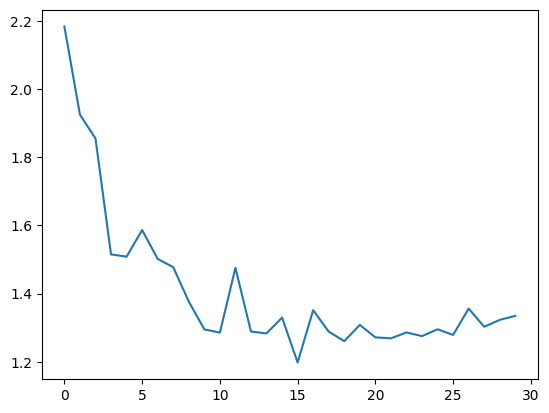

In [ ]:
plt.plot(loss_list)

In [ ]:
#torch.save(model_mask.state_dict(), '/content/drive/MyDrive/Projet_DL/state_dict/mask_only/pretrained_Unet_10_epochs_10-3_bs50')

## Model for label prediction

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights


# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model_label = resnet50(weights=weights)
num_features = model_label.fc.in_features
model_label.fc = nn.Linear(num_features, 3)


# Step 2: Initialize the inference transforms
preprocess = weights.transforms()


In [ ]:
train_dataset_label = CustomDataset_label(train_df, us_transform, preprocess)
valid_dataset_label = CustomDataset_label(valid_df, us_transform, preprocess)
test_dataset_label = CustomDataset_label(test_df, us_transform, preprocess)

In [ ]:
BATCH_SIZE = 10

train_dataloader_label = DataLoader(dataset = train_dataset_label, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader_label = DataLoader(dataset = valid_dataset_label, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_label = DataLoader(dataset = test_dataset_label, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
N_EPOCHS = 10
LR = 1e-3

model_label = model_label.to(device)
loss_fn = nn.CrossEntropyLoss() # Sigmoid layer and the BCELoss in one single class.
opt = optim.Adam(model_label.parameters(), lr = LR)

In [ ]:
model_label

In [ ]:
def train_loop_label(dataloader, model, loss_fn, opt):
    size = len(dataloader.dataset)
    
    for batch, (mask, label) in enumerate(dataloader):
        mask = mask.to(device)
        label = label.to(device)

        # Compute prediction and loss
        label_logits = model(mask)
        
        loss_label =  loss_fn(label_logits, label.argmax(1))
        opt.zero_grad()
        loss_label.backward()
        
        opt.step()

        # Backpropagation
        """
        optimizer.zero_grad()
        loss_mask.backward(retain_graph = True)
        loss_label.backward()
        optimizer.step()
        """     

        if batch % 50 == 0:
            loss_label, current = loss_label.item(), batch * len(mask)
            print(f"train label loss: {loss_label} [{current}/{size}]")


def test_loop_label(dataloader, model, loss_fn, create_list = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_label_list = []
    true_label = []
    pred_label = []
    with torch.no_grad():
        
        for mask, label in dataloader:
            if create_list == True:
              true_label_list += label.tolist()
              
            mask = mask.to(device)
            label = label.to(device)            

            label_logits = model(mask)
            loss_label =  loss_fn(label_logits, label.argmax(1))
            
            test_loss += loss_label.item()
            correct += (label.argmax(1) == label_logits.argmax(1)).type(torch.float).sum().item()

            if create_list == True:
              for pred in label_logits:
                argmax = torch.argmax(pred)
                if argmax == 0: pred_label += ["Normal"]
                elif argmax == 1: pred_label+= ["Benign"]
                else: pred_label+= ["Malignant"]

    if create_list == True:
      for label in true_label_list:
        if label == list([1,0,0]): true_label.append('Normal')
        elif label == list([0,1,0]): true_label.append('Benign')
        else: true_label.append('Malignant')

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss} \n")
    print(f"Test Error Label : {test_loss};  Accuracy: {(100*correct):>0.1f}% \n")
    if create_list == True:
      return test_loss, true_label, pred_label
    else: 
      return test_loss

In [ ]:
#torch.autograd.set_detect_anomaly(True)
loss_list = []
for t in range(N_EPOCHS-1):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_label(train_dataloader_label, model_label,  loss_fn, opt)
    val_loss = test_loop_label(valid_dataloader_label, model_label, loss_fn)
    loss_list.append(val_loss)

print(f"Epoch final\n-------------------------------")
train_loop_label(train_dataloader_label, model_label,  loss_fn, opt)
val_loss, true_label, pred_label = test_loop_label(valid_dataloader_label, model_label, loss_fn, create_list = True)
loss_list.append(val_loss)

print("Done!")

In [ ]:
plt.plot(loss_list)

In [ ]:
test_loss, true_label_val, pred_label_val = test_loop_label(valid_dataloader_label, model_label, loss_fn, create_list = True)

In [ ]:
# Visualisation sur le dataset de validation

import seaborn as sns
import matplotlib.pyplot as plt  

cm = sklearn.metrics.confusion_matrix(true_label_val, pred_label_val)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']); ax.yaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']);

In [ ]:
# Visulisation sur le dataset de test

test_loss, true_label_test, pred_label_test = test_loop_label(test_dataloader_label, model_label, loss_fn, create_list = True)

cm_test = sklearn.metrics.confusion_matrix(true_label_test, pred_label_test)

ax= plt.subplot()
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for testing dataset'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']); ax.yaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']);

In [ ]:

#torch.save(model_label.state_dict(), '/content/drive/MyDrive/Projet_DL/state_dict/label_only/pretrained_ResNet50_10_epochs_10-3_bs10')

## Model Predictions

### Mask prediction

In [ ]:
PATH_mask = '/content/drive/MyDrive/Projet_DL/state_dict/mask_only/pretrained_unet_20_epochs_10-3_bs100_test'

Encoder = 'resnet34'
Weights = 'imagenet'

model_mask = smp.Unet(
    encoder_name = Encoder,
    encoder_weights = Weights,
    in_channels = 3,
    classes = 1, # tumeur 
    activation = None,
)

model_mask = model_mask.to(device)
model_mask.load_state_dict(torch.load(PATH_mask, map_location=torch.device('cpu')))
model_mask.eval()

### Label prediction

In [ ]:
PATH_label = '/content/drive/MyDrive/Projet_DL/state_dict/label_only/pretrained_ResNet50_10_epochs_10-3_bs10'

weights = ResNet50_Weights.DEFAULT
model_label = resnet50(weights=weights)
num_features = model_label.fc.in_features
model_label.fc = nn.Linear(num_features, 3)

model_label = model_label.to(device)
model_label.load_state_dict(torch.load(PATH_label, map_location=torch.device('cpu')))
model_label.eval()

In [ ]:
# visualisation des résultats pour ce modèle 

def visualization_predictions(pytorch_dataset, model_label, number = 8):
    """ Show random images with label from pytorch dataset."""

    figure = plt.figure(figsize= (10,20))
    cols, rows = 3, number 
    for i in range(1, 3 * number + 1,3):
        
        sample_idx = torch.randint(len(pytorch_dataset), size=(1,)).item()
        mask_img, label = pytorch_dataset.__getitem__(sample_idx)
        #print(mask_img.shape)
        
        if label[0].item() == 1. : label = "normal" 
        elif label[1].item() == 1. : label = "benign"
        elif  label[2].item() == 1. : label = "malignant"
        
        
        figure.add_subplot(rows, cols, i + 1)
        plt.title(f"Target : {label}")
        plt.axis("off")
        plt.imshow(mask_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        mask_img = mask_img.to(device)
        mask_img = mask_img.unsqueeze_(0)
        #print(mask_img.shape)

        label_pred = model_label(mask_img)
        print(label_pred)
        #print(torch.round(label_pred))
        #print(torch.argmax(torch.abs(label_pred)))


        if torch.argmax(label_pred).item() == 0. : print('label_pred = normal') 
        elif torch.argmax(label_pred).item() == 1 : print('label_pred = benign') 
        elif  torch.argmax(label_pred).item() == 2 : print('label_pred = malignant') 

        
    plt.show()

In [ ]:
train_dataset_label = CustomDataset_label(train_df, us_transform, preprocess)
valid_dataset_label = CustomDataset_label(valid_df, us_transform, preprocess)
test_dataset_label = CustomDataset_label(test_df, us_transform, preprocess)

In [ ]:
visualization_predictions(test_dataset_label, model_label, number = 8)

### Visualisations 

In [ ]:
def custom_threshold(x, threshold):
  return torch.nn.functional.threshold(torch.round(x+0.5-threshold), 0.5, 0)

In [ ]:
def visualization_predictions_final(pytorch_dataset, model_mask, model_label, number = 8):
    """ Show random images with label from pytorch dataset."""

    figure = plt.figure(figsize= (10,20))
    cols, rows = 3, number 
    for i in range(1, 3 * number + 1,3):
        
        sample_idx = torch.randint(len(pytorch_dataset), size=(1,)).item()
        ultrasound_img, mask_img, label = pytorch_dataset.__getitem__(sample_idx)
        
        if label[0].item() == 1. : label = "normal" 
        elif label[1].item() == 1. : label = "benign"
        elif  label[2].item() == 1. : label = "malignant"
        
        figure.add_subplot(rows, cols, i)
        plt.title("Ultrasound Image")
        plt.axis("off")
        plt.imshow(ultrasound_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        figure.add_subplot(rows, cols, i + 1)
        plt.title(f"Target : {label}")
        plt.axis("off")
        plt.imshow(mask_img.permute(1, 2, 0).squeeze(),cmap='gray')
        
        figure.add_subplot(rows, cols, i + 2)
        ultrasound_img = ultrasound_img[None, :, :, :] # add dimension
        ultrasound_img = ultrasound_img.to(device) # load to gpu
        mask_pred = model_mask(ultrasound_img)
        mask_pred = torch.sigmoid(mask_pred)
        #mask_pred = torch.round(mask_pred)
        mask_pred = custom_threshold(mask_pred, 0.80)

        mask_pred_RGB = mask_pred.squeeze_(0)
        mask_pred_RGB = mask_pred_RGB.repeat(3, 1, 1)
        mask_pred_RGB = mask_pred_RGB.unsqueeze_(0)
        #print(mask_pred_RGB.shape)

        label_pred = model_label(mask_pred_RGB)
        print(label_pred)
        #label_pred = torch.sigmoid(label_pred)
        #print(label_pred)
        

        mask_pred.unsqueeze_(dim = 0)
        mask_pred = torch.squeeze(mask_pred,dim = 0).cpu() # remove dimension and put on cpu

        if label_pred[0][0].item() > 0. : label_pred = "normal" 
        elif (torch.argmax(label_pred).item() == 1) or ((torch.argmax(label_pred).item() == 2) and (label_pred[0][1].item() > 0.)) : label_pred = "benign"
        elif  (torch.argmax(label_pred).item() == 2) and (label_pred[0][1].item() < 0.) : label_pred = "malignant"

        #if torch.argmax(label_pred).item() == 0. : label_pred = 'normal' 
        #elif torch.argmax(label_pred).item() == 1 : label_pred = 'benign' 
        #elif  torch.argmax(label_pred).item() == 2 : label_pred = 'malignant' 

        plt.title(f"Prediction :{label_pred}")
        plt.axis("off")
        plt.imshow(mask_pred.detach().permute(1, 2, 0).squeeze(),cmap='gray')
        
    plt.show()

In [ ]:
test_dataset_mask = CustomDataset_mask(test_df, us_transform, mask_transform, print_label = True)

In [ ]:
_ = torch.manual_seed(25)

visualization_predictions_final(test_dataset_mask, model_mask, model_label, number = 15)

### Prédictions combinées : matrices de confusion


In [ ]:
test_dataset_mask = CustomDataset_mask(test_df, us_transform, mask_transform, print_label = True)
test_dataloader_mask = DataLoader(dataset = test_dataset_mask, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
def test_combined_model(dataloader, model_mask, model_label, create_list = False):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_label_list = []
    true_label = []
    pred_label = []
    with torch.no_grad():
        
        for ultrasound, mask, label in dataloader:
            if create_list == True:
              true_label_list += label.tolist()

            ultrasound = ultrasound.to(device) 
            mask = mask.to(device)
            label = label.to(device)
            
            mask_pred = model_mask(ultrasound)
            mask_pred = torch.sigmoid(mask_pred)
            #mask_pred = torch.round(mask_pred)
            mask_pred = custom_threshold(mask_pred, 0.5)

            mask_pred_RGB = mask_pred.repeat(1, 3, 1, 1)

            label_logits = model_label(mask_pred_RGB)
            
            correct += (label.argmax(1) == label_logits.argmax(1)).type(torch.float).sum().item()

            if create_list == True:
              for label_pred in label_logits:
                #print(label_pred)
                argmax = torch.argmax(label_pred)
                #if argmax == 0: pred_label += ["Normal"]
                #elif argmax == 1: pred_label+= ["Benign"]
                #else: pred_label+= ["Malignant"]
                if label_pred[0].item() > 0. : pred_label.append("Normal")
                elif (torch.argmax(label_pred).item() == 1) or ((torch.argmax(label_pred).item() == 2) and (label_pred[1].item() > 0.)) : pred_label.append("Benign")
                else : pred_label.append("Malignant")

    if create_list == True:
      for label in true_label_list:
        if label == list([1,0,0]): true_label.append('Normal')
        elif label == list([0,1,0]): true_label.append('Benign')
        else: true_label.append('Malignant')
      
      print(len(true_label))
      print(len(pred_label))

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss} \n")
    print(f"Test Error Label : {test_loss};  Accuracy: {(100*correct):>0.1f}% \n")
    if create_list == True:
      return test_loss, true_label, pred_label
    else: 
      return test_loss

In [ ]:
# Sur le dataset de train 

test_loss, true_label_test, pred_label_test = test_combined_model(test_dataloader_mask, model_mask, model_label, create_list = True)

In [ ]:
cm_test = sklearn.metrics.confusion_matrix(true_label_test, pred_label_test)

ax= plt.subplot()
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for testing dataset - Threasold = 0.5'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']); ax.yaxis.set_ticklabels(['Benign', 'Malignant', 'Normal']);